🔍 Analyzing dataset: E:\roboarmsimulation\robot_demos_20250708_115502\demonstrations_11.hdf5


Processing demos:   0%|          | 0/1 [00:00<?, ?it/s]


📊 Dataset statistics:
Proprioceptive features: 20
  Mean range: [-1.9266, 1.8307]
  Std range: [0.0004, 0.6837]
Action features: 7
  Mean range: [-1.9266, 1.8307]
  Std range: [0.0004, 0.6283]
Trajectory features: 3
  Mean range: [0.0000, 0.6000]
  Std range: [1.0000, 1.0000]
RGB scaling: 255.0
Depth scaling: 1.0
🔄 Normalizing dataset: E:\roboarmsimulation\robot_demos_20250708_115502\demonstrations_11.hdf5 → E:\roboarmsimulation\robot_demos_20250708_115502\demonstrations_11_normalized.hdf5


Normalizing demos:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Normalization complete: E:\roboarmsimulation\robot_demos_20250708_115502\demonstrations_11_normalized.hdf5


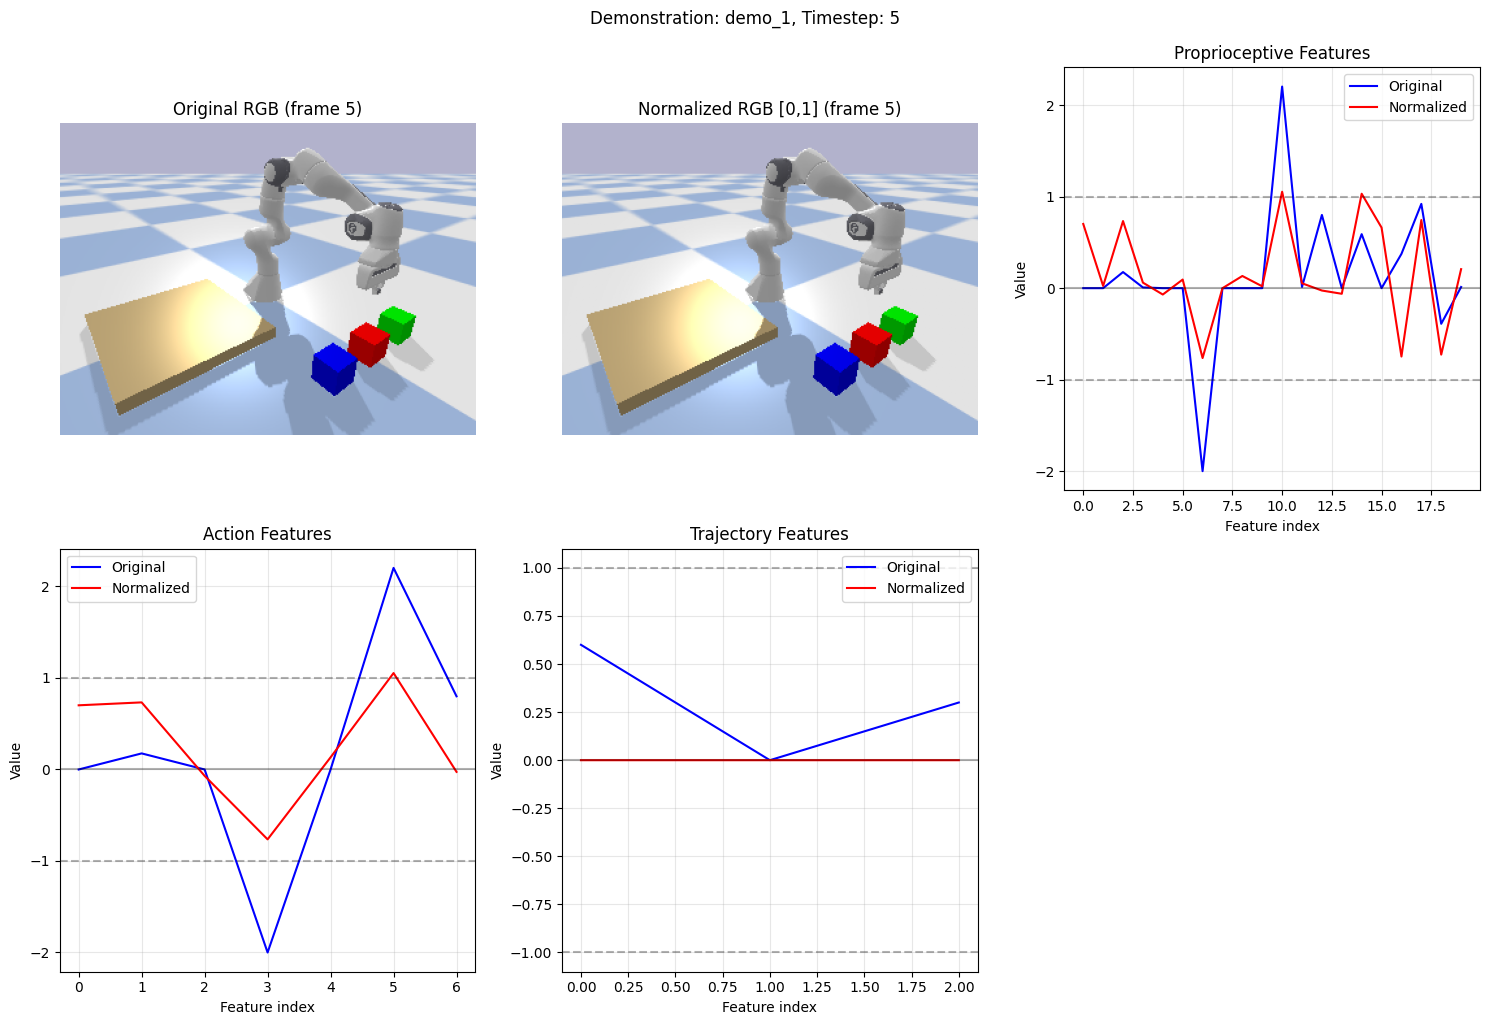

In [1]:
import numpy as np
import h5py
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

class RobotDataNormalizer:
    """
    Normalizes robotics HDF5 dataset for machine learning:
    - RGB/Depth: Scale to [0,1]
    - Proprioceptive: Standardize (zero-mean, unit-variance)
    - Actions: Standardize (zero-mean, unit-variance)
    - Trajectory: Standardize (zero-mean, unit-variance)
    """
    
    def __init__(self, source_file, target_file=None):
        """
        Initialize normalizer
        
        Args:
            source_file: Path to source HDF5 file
            target_file: Path to target normalized HDF5 file (if None, creates one)
        """
        self.source_file = source_file
        
        if target_file is None:
            # Auto-generate target filename
            base, ext = os.path.splitext(source_file)
            self.target_file = f"{base}_normalized{ext}"
        else:
            self.target_file = target_file
            
        # Statistics dictionaries
        self.stats = {
            'rgb_scale': 255.0,  # Default scaling for RGB
            'depth_scale': None,  # Will be calculated
            'proprio_mean': None,
            'proprio_std': None,
            'action_mean': None, 
            'action_std': None,
            'traj_mean': None,
            'traj_std': None
        }
        
    def analyze_dataset(self):
        """Calculate statistics needed for normalization"""
        print(f"🔍 Analyzing dataset: {self.source_file}")
        
        with h5py.File(self.source_file, 'r') as f:
            if 'data' not in f:
                raise ValueError("No 'data' group found in HDF5 file")
                
            # Get first demo as reference
            demos = list(f['data'].keys())
            if not demos:
                raise ValueError("No demonstrations found in HDF5 file")
                
            # Collect statistics across all demonstrations
            all_proprio = []
            all_actions = []
            all_trajs = []
            depth_min, depth_max = float('inf'), float('-inf')
            
            for demo_name in tqdm(demos, desc="Processing demos"):
                demo = f['data'][demo_name]
                
                # Depth statistics (if available)
                if 'obs' in demo and 'depth' in demo['obs']:
                    depth = demo['obs']['depth'][:]
                    if depth.size > 0:  # Only if there's data
                        depth_min = min(depth_min, np.min(depth))
                        depth_max = max(depth_max, np.max(depth))
                
                # Collect proprioceptive data
                if 'obs' in demo and 'proprio' in demo['obs']:
                    proprio = demo['obs']['proprio'][:]
                    if proprio.size > 0:
                        all_proprio.append(proprio)
                
                # Collect action data
                if 'actions' in demo:
                    actions = demo['actions'][:]
                    if actions.size > 0:
                        all_actions.append(actions)
                
                # Collect trajectory data
                if 'traj' in demo and 'future' in demo['traj']:
                    traj = demo['traj']['future'][:]
                    if traj.size > 0:
                        all_trajs.append(traj)
            
            # Combine and compute statistics
            if all_proprio:
                all_proprio = np.vstack(all_proprio)
                self.stats['proprio_mean'] = np.mean(all_proprio, axis=0)
                self.stats['proprio_std'] = np.std(all_proprio, axis=0)
                # Handle zeros in std
                self.stats['proprio_std'] = np.where(
                    self.stats['proprio_std'] < 1e-5, 
                    np.ones_like(self.stats['proprio_std']), 
                    self.stats['proprio_std']
                )
                
            if all_actions:
                all_actions = np.vstack(all_actions)
                self.stats['action_mean'] = np.mean(all_actions, axis=0)
                self.stats['action_std'] = np.std(all_actions, axis=0)
                # Handle zeros in std
                self.stats['action_std'] = np.where(
                    self.stats['action_std'] < 1e-5, 
                    np.ones_like(self.stats['action_std']), 
                    self.stats['action_std']
                )
                
            if all_trajs:
                all_trajs = np.vstack(all_trajs)
                self.stats['traj_mean'] = np.mean(all_trajs, axis=0)
                self.stats['traj_std'] = np.std(all_trajs, axis=0)
                # Handle zeros in std
                self.stats['traj_std'] = np.where(
                    self.stats['traj_std'] < 1e-5, 
                    np.ones_like(self.stats['traj_std']), 
                    self.stats['traj_std']
                )
            
            # Set depth scaling
            if depth_min != float('inf') and depth_max != float('-inf'):
                self.stats['depth_scale'] = depth_max - depth_min
            else:
                self.stats['depth_scale'] = 1.0  # Default if no depth data
            
        # Print statistics summary
        print("\n📊 Dataset statistics:")
        if self.stats['proprio_mean'] is not None:
            print(f"Proprioceptive features: {len(self.stats['proprio_mean'])}")
            print(f"  Mean range: [{np.min(self.stats['proprio_mean']):.4f}, {np.max(self.stats['proprio_mean']):.4f}]")
            print(f"  Std range: [{np.min(self.stats['proprio_std']):.4f}, {np.max(self.stats['proprio_std']):.4f}]")
            
        if self.stats['action_mean'] is not None:
            print(f"Action features: {len(self.stats['action_mean'])}")
            print(f"  Mean range: [{np.min(self.stats['action_mean']):.4f}, {np.max(self.stats['action_mean']):.4f}]")
            print(f"  Std range: [{np.min(self.stats['action_std']):.4f}, {np.max(self.stats['action_std']):.4f}]")
            
        if self.stats['traj_mean'] is not None:
            print(f"Trajectory features: {len(self.stats['traj_mean'])}")
            print(f"  Mean range: [{np.min(self.stats['traj_mean']):.4f}, {np.max(self.stats['traj_mean']):.4f}]")
            print(f"  Std range: [{np.min(self.stats['traj_std']):.4f}, {np.max(self.stats['traj_std']):.4f}]")
            
        print(f"RGB scaling: {self.stats['rgb_scale']}")
        print(f"Depth scaling: {self.stats['depth_scale']}")
        
        return self.stats
    
    def normalize_data(self):
        """Normalize dataset based on calculated statistics"""
        # First ensure we have statistics
        if self.stats['proprio_mean'] is None:
            self.analyze_dataset()
            
        print(f"🔄 Normalizing dataset: {self.source_file} → {self.target_file}")
        
        # Create output file
        with h5py.File(self.source_file, 'r') as src, \
             h5py.File(self.target_file, 'w') as dst:
            
            # Copy structure and metadata
            if 'metadata' in src:
                src.copy('metadata', dst)
            
            # Create data group
            if 'data' not in dst:
                dst.create_group('data')
            
            # Add normalization metadata
            norm_group = dst.create_group('normalization')
            
            # Store statistics as attributes and datasets
            for key, value in self.stats.items():
                if value is None:
                    continue
                if isinstance(value, (int, float)):
                    norm_group.attrs[key] = value
                else:
                    norm_group.create_dataset(key, data=value)
            
            # Process each demonstration
            demos = list(src['data'].keys())
            for demo_name in tqdm(demos, desc="Normalizing demos"):
                src_demo = src['data'][demo_name]
                dst_demo = dst['data'].create_group(demo_name)
                
                # Copy attributes
                for key, value in src_demo.attrs.items():
                    dst_demo.attrs[key] = value
                
                # Normalize observations
                if 'obs' in src_demo:
                    obs_group = dst_demo.create_group('obs')
                    
                    # Normalize RGB (0-255 to 0-1)
                    if 'rgb' in src_demo['obs']:
                        rgb = src_demo['obs']['rgb'][:]
                        normalized_rgb = rgb.astype(np.float32) / self.stats['rgb_scale']
                        obs_group.create_dataset('rgb', data=normalized_rgb, 
                                               compression='gzip', compression_opts=4)
                    
                    # Normalize depth (min-max to 0-1)
                    if 'depth' in src_demo['obs'] and self.stats['depth_scale'] > 0:
                        depth = src_demo['obs']['depth'][:]
                        if depth.size > 0:
                            normalized_depth = depth.astype(np.float32) / self.stats['depth_scale']
                            obs_group.create_dataset('depth', data=normalized_depth, 
                                                   compression='gzip', compression_opts=4)
                        else:
                            # Create empty dataset with same structure
                            obs_group.create_dataset('depth', shape=src_demo['obs']['depth'].shape,
                                                   dtype=np.float32, compression='gzip')
                    
                    # Standardize proprioceptive data
                    if 'proprio' in src_demo['obs'] and self.stats['proprio_mean'] is not None:
                        proprio = src_demo['obs']['proprio'][:]
                        if proprio.size > 0:
                            normalized_proprio = (proprio - self.stats['proprio_mean']) / self.stats['proprio_std']
                            obs_group.create_dataset('proprio', data=normalized_proprio)
                        else:
                            # Create empty dataset with same structure
                            obs_group.create_dataset('proprio', shape=src_demo['obs']['proprio'].shape,
                                                   dtype=np.float32)
                
                # Standardize actions
                if 'actions' in src_demo and self.stats['action_mean'] is not None:
                    actions = src_demo['actions'][:]
                    if actions.size > 0:
                        normalized_actions = (actions - self.stats['action_mean']) / self.stats['action_std']
                        dst_demo.create_dataset('actions', data=normalized_actions)
                    else:
                        dst_demo.create_dataset('actions', shape=src_demo['actions'].shape,
                                              dtype=np.float32)
                
                # Create trajectory group
                if 'traj' in src_demo:
                    traj_group = dst_demo.create_group('traj')
                    
                    # Standardize future trajectory
                    if 'future' in src_demo['traj'] and self.stats['traj_mean'] is not None:
                        traj = src_demo['traj']['future'][:]
                        if traj.size > 0:
                            normalized_traj = (traj - self.stats['traj_mean']) / self.stats['traj_std']
                            traj_group.create_dataset('future', data=normalized_traj)
                        else:
                            traj_group.create_dataset('future', shape=src_demo['traj']['future'].shape,
                                                    dtype=np.float32)
        
        print(f"✅ Normalization complete: {self.target_file}")
        return self.target_file

    def visualize_normalization(self, demo_idx=0, timestep=0):
        """Visualize original vs normalized data"""
        with h5py.File(self.source_file, 'r') as src, \
             h5py.File(self.target_file, 'r') as dst:
            
            demos = list(src['data'].keys())
            if not demos:
                print("No demonstrations found")
                return
            
            # Select demo and timestep
            demo_name = demos[min(demo_idx, len(demos)-1)]
            src_demo = src['data'][demo_name]
            dst_demo = dst['data'][demo_name]
            
            # Setup figure
            fig = plt.figure(figsize=(15, 10))
            
            # 1. Visualize RGB normalization
            if 'rgb' in src_demo['obs'] and 'rgb' in dst_demo['obs']:
                timesteps = src_demo['obs']['rgb'].shape[0]
                ts = min(timestep, timesteps-1)
                
                src_rgb = src_demo['obs']['rgb'][ts]
                dst_rgb = dst_demo['obs']['rgb'][ts]
                
                plt.subplot(2, 3, 1)
                plt.title(f"Original RGB (frame {ts})")
                plt.imshow(np.transpose(src_rgb, (1, 2, 0)).astype(np.uint8))
                plt.axis('off')
                
                plt.subplot(2, 3, 2)
                plt.title(f"Normalized RGB [0,1] (frame {ts})")
                plt.imshow(np.transpose(dst_rgb, (1, 2, 0)))
                plt.axis('off')
            
            # 2. Visualize proprio normalization
            if 'proprio' in src_demo['obs'] and 'proprio' in dst_demo['obs']:
                plt.subplot(2, 3, 3)
                plt.title("Proprioceptive Features")
                
                src_proprio = src_demo['obs']['proprio'][:]
                dst_proprio = dst_demo['obs']['proprio'][:]
                
                if src_proprio.size > 0 and dst_proprio.size > 0:
                    x = np.arange(src_proprio.shape[1])
                    plt.plot(x, src_proprio[timestep], 'b-', label='Original')
                    plt.plot(x, dst_proprio[timestep], 'r-', label='Normalized')
                    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
                    plt.axhline(y=1, color='k', linestyle='--', alpha=0.3)
                    plt.axhline(y=-1, color='k', linestyle='--', alpha=0.3)
                    plt.legend()
                    plt.xlabel("Feature index")
                    plt.ylabel("Value")
                    plt.grid(True, alpha=0.3)
            
            # 3. Visualize actions normalization
            if 'actions' in src_demo and 'actions' in dst_demo:
                plt.subplot(2, 3, 4)
                plt.title("Action Features")
                
                src_actions = src_demo['actions'][:]
                dst_actions = dst_demo['actions'][:]
                
                if src_actions.size > 0 and dst_actions.size > 0:
                    x = np.arange(src_actions.shape[1])
                    plt.plot(x, src_actions[timestep], 'b-', label='Original')
                    plt.plot(x, dst_actions[timestep], 'r-', label='Normalized')
                    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
                    plt.axhline(y=1, color='k', linestyle='--', alpha=0.3)
                    plt.axhline(y=-1, color='k', linestyle='--', alpha=0.3)
                    plt.legend()
                    plt.xlabel("Feature index")
                    plt.ylabel("Value")
                    plt.grid(True, alpha=0.3)
            
            # 4. Visualize trajectory normalization
            if 'traj' in src_demo and 'future' in src_demo['traj'] and \
               'traj' in dst_demo and 'future' in dst_demo['traj']:
                plt.subplot(2, 3, 5)
                plt.title("Trajectory Features")
                
                src_traj = src_demo['traj']['future'][:]
                dst_traj = dst_demo['traj']['future'][:]
                
                if src_traj.size > 0 and dst_traj.size > 0:
                    x = np.arange(src_traj.shape[1])
                    plt.plot(x, src_traj[timestep], 'b-', label='Original')
                    plt.plot(x, dst_traj[timestep], 'r-', label='Normalized')
                    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
                    plt.axhline(y=1, color='k', linestyle='--', alpha=0.3)
                    plt.axhline(y=-1, color='k', linestyle='--', alpha=0.3)
                    plt.legend()
                    plt.xlabel("Feature index")
                    plt.ylabel("Value")
                    plt.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.suptitle(f"Demonstration: {demo_name}, Timestep: {timestep}", y=1.02)
            plt.show()
            
    def get_normalization_params(self):
        """Return normalization parameters for use in models"""
        return self.stats

# Example usage:
input_file = "E:\\roboarmsimulation\\robot_demos_20250708_115502\demonstrations_11.hdf5"  # Replace with your HDF5 file path
# For demonstration, we'll use a sample path - replace with your actual path
# input_file = "robot_demos_20250623_123456/demonstrations_20250623_123456.hdf5"

# Usage example (uncomment to use):
normalizer = RobotDataNormalizer(input_file)
normalizer.analyze_dataset()  # Calculate statistics
normalizer.normalize_data()   # Create normalized version
normalizer.visualize_normalization(demo_idx=0, timestep=5)  # Show example

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np

class RobotDemonstrationDataset(Dataset):
    """PyTorch Dataset for normalized robot demonstrations from HDF5 files"""
    
    def __init__(self, hdf5_file, demo_keys=None, sequence_length=1, skip_frames=1, debug=False):
        """
        Args:
            hdf5_file: Path to normalized HDF5 file
            demo_keys: List of specific demonstrations to use (if None, uses all)
            sequence_length: Number of consecutive frames to return
            skip_frames: Number of frames to skip between samples
            debug: Set to True to enable detailed validation diagnostics
        """
        self.hdf5_file = hdf5_file
        self.sequence_length = sequence_length
        self.skip_frames = skip_frames
        self.debug = debug
        
        # Instead of keeping file open, just open it temporarily for initialization
        with h5py.File(hdf5_file, 'r') as f:
            # Get all valid demos or filter by provided keys
            all_demos = list(f['data'].keys())
            self.demo_keys = demo_keys if demo_keys is not None else all_demos
            
            # Pre-compute valid indices for faster access during training
            self.valid_indices = []
            
            # Diagnostic counters
            if debug:
                self.validation_stats = {
                    'total_demos': len(self.demo_keys),
                    'missing_obs': 0,
                    'missing_rgb': 0,
                    'missing_proprio': 0,
                    'missing_actions': 0,
                    'missing_traj': 0,
                    'missing_future': 0,
                    'empty_rgb': 0,
                    'sequence_too_short': 0,
                    'valid_demos': 0
                }
            
            # Check each demo for validity and compute indices
            for demo_key in self.demo_keys:
                demo = f['data'][demo_key]
                
                # Use the validation logic you already have
                if self.debug:
                    # Safety check each field separately for diagnostics
                    if 'obs' not in demo:
                        self.validation_stats['missing_obs'] += 1
                        continue
                    if 'rgb' not in demo['obs']:  # This avoids the KeyError
                        self.validation_stats['missing_rgb'] += 1
                        continue
                    # ... rest of your validation logic ...
                else:
                    # Use your existing validation method
                    if not self._is_valid_demo_file(demo):
                        continue
                
                # Get number of frames in this demo
                num_frames = demo['obs']['rgb'].shape[0]
                
                # Check if demo has enough frames for the sequence
                if num_frames < (self.sequence_length * skip_frames):
                    if self.debug:
                        self.validation_stats['sequence_too_short'] += 1
                    continue
                
                # Demo is valid
                if self.debug:
                    self.validation_stats['valid_demos'] += 1
                
                # Add all valid sequence starting points
                for start_idx in range(0, num_frames - (self.sequence_length * skip_frames) + 1, skip_frames):
                    self.valid_indices.append((demo_key, start_idx))
            
            # ... rest of your validation reporting code ...
    
    def __len__(self):
        """Return number of valid samples"""
        return len(self.valid_indices)
    
    def __getitem__(self, idx):
        """Return a single sequence sample at the given index"""
        demo_key, start_idx = self.valid_indices[idx]
        
        # Open file for each access - solves the pickling issue
        with h5py.File(self.hdf5_file, 'r') as f:
            demo = f['data'][demo_key]
            
            # Extract sequence of frames
            rgb_seq = []
            proprio_seq = []
            action_seq = []
            traj_seq = []
            
            for i in range(self.sequence_length):
                frame_idx = start_idx + i * self.skip_frames
                
                # Get RGB (convert to torch tensor)
                rgb = torch.tensor(demo['obs']['rgb'][frame_idx], dtype=torch.float32)
                
                # Get proprioceptive data
                proprio = torch.tensor(demo['obs']['proprio'][frame_idx], dtype=torch.float32)
                
                # Get action
                action = torch.tensor(demo['actions'][frame_idx], dtype=torch.float32)
                
                # Get trajectory (if available)
                if 'traj' in demo and 'future' in demo['traj']:
                    traj = torch.tensor(demo['traj']['future'][frame_idx], dtype=torch.float32)
                else:
                    # Create dummy trajectory if not available
                    traj = torch.zeros(action.shape, dtype=torch.float32)
                
                rgb_seq.append(rgb)
                proprio_seq.append(proprio)
                action_seq.append(action)
                traj_seq.append(traj)
            
            # Stack sequences
            rgb_seq = torch.stack(rgb_seq)       # [seq_len, C, H, W]
            proprio_seq = torch.stack(proprio_seq)  # [seq_len, proprio_dim]
            action_seq = torch.stack(action_seq)    # [seq_len, action_dim]
            traj_seq = torch.stack(traj_seq)        # [seq_len, traj_dim]
        
        return {
            'rgb': rgb_seq,
            'proprio': proprio_seq,
            'action': action_seq,
            'traj_future': traj_seq
        }
        
    # Add this validation method for use during initialization
    def _is_valid_demo_file(self, demo):
        """Check if a demonstration has all required data (used during file scanning)"""
        # Check basic structure
        if 'obs' not in demo:
            return False
        if 'rgb' not in demo['obs'] or 'proprio' not in demo['obs']:
            return False
        if 'actions' not in demo:
            return False
        if demo['obs']['rgb'].shape[0] == 0:
            return False
        if 'traj' in demo and 'future' in demo['traj']:
          if frame_idx < demo['traj']['future'].shape[0]:
           traj = torch.tensor(demo['traj']['future'][frame_idx], dtype=torch.float32)
          else:
           traj = torch.zeros_like(action)
        # Optionally check for trajectory data shape, but do not require it
        # (since you already handle missing traj in __getitem__)
        return True

In [3]:
# Add num_workers parameter to the function
def create_robot_data_loaders_fixed(hdf5_file, batch_size=16, val_split=0.1, 
                                   sequence_length=1, skip_frames=1, num_workers=0):
    """Fixed version that handles single-demo cases"""
    with h5py.File(hdf5_file, 'r') as f:
        all_demos = list(f['data'].keys())
    
    if len(all_demos) <= 1:
        print("⚠️ Only one demo found - using same demo for training and validation")
        train_demos = all_demos
        val_demos = all_demos
    else:
        np.random.shuffle(all_demos)
        split_idx = max(1, min(int(val_split * len(all_demos)), len(all_demos) - 1))
        val_demos = all_demos[:split_idx]
        train_demos = all_demos[split_idx:]
    
    train_dataset = RobotDemonstrationDataset(
        hdf5_file, demo_keys=train_demos, sequence_length=sequence_length,
        skip_frames=skip_frames, debug=True
    )
    
    val_dataset = RobotDemonstrationDataset(
        hdf5_file, demo_keys=val_demos, sequence_length=sequence_length,
        skip_frames=skip_frames, debug=True
    )
    
    # Use num_workers=0 to disable multiprocessing
    train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                             shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, 
                           shuffle=False, num_workers=0)
    
    return train_loader, val_loader

In [4]:
if __name__ == "__main__":
    normalized_file = "E:\\roboarmsimulation\\robot_demos_20250708_115502\demonstrations_11_normalized.hdf5"
    
    # Create data loaders
    train_loader, val_loader = create_robot_data_loaders_fixed(
        hdf5_file=normalized_file,
        batch_size=8,
        val_split=0.2,
        sequence_length=5,
        skip_frames=1,
     
        
    )
    
    # Display a sample batch
    for batch_idx, batch in enumerate(train_loader):
        print(f"Batch {batch_idx} shapes:")
        print(f"  RGB: {batch['rgb'].shape}")
        print(f"  Proprio: {batch['proprio'].shape}")
        print(f"  Action: {batch['action'].shape}")
        print(f"  Trajectory: {batch['traj_future'].shape}")
        break  # Just show the first batch

⚠️ Only one demo found - using same demo for training and validation
Batch 0 shapes:
  RGB: torch.Size([8, 5, 3, 240, 320])
  Proprio: torch.Size([8, 5, 20])
  Action: torch.Size([8, 5, 7])
  Trajectory: torch.Size([8, 5, 3])


⚠️ Only one demo found - using same demo for training and validation
Using device: cuda


Validating: 100%|██████████| 27/27 [00:32<00:00,  1.21s/it]


Epoch 1/20 - Train Loss: 1.008993, Val Loss: 0.998494


Validating: 100%|██████████| 27/27 [00:27<00:00,  1.01s/it]


Epoch 2/20 - Train Loss: 0.966163, Val Loss: 0.901704


Validating: 100%|██████████| 27/27 [00:16<00:00,  1.59it/s]


Epoch 3/20 - Train Loss: 0.806982, Val Loss: 0.715490


Validating: 100%|██████████| 27/27 [00:17<00:00,  1.58it/s]


Epoch 4/20 - Train Loss: 0.689059, Val Loss: 0.645495


Validating: 100%|██████████| 27/27 [00:16<00:00,  1.60it/s]


Epoch 5/20 - Train Loss: 0.627465, Val Loss: 0.598861


Validating: 100%|██████████| 27/27 [00:17<00:00,  1.57it/s]


Epoch 6/20 - Train Loss: 0.598158, Val Loss: 0.599050


Validating: 100%|██████████| 27/27 [00:16<00:00,  1.59it/s]


Epoch 7/20 - Train Loss: 0.575273, Val Loss: 0.555951


Validating: 100%|██████████| 27/27 [00:17<00:00,  1.58it/s]


Epoch 8/20 - Train Loss: 0.553588, Val Loss: 0.534226


Validating: 100%|██████████| 27/27 [00:20<00:00,  1.30it/s]


Epoch 9/20 - Train Loss: 0.535152, Val Loss: 0.517292


Validating: 100%|██████████| 27/27 [00:21<00:00,  1.28it/s]


Epoch 10/20 - Train Loss: 0.517929, Val Loss: 0.506160


Validating: 100%|██████████| 27/27 [00:19<00:00,  1.40it/s]


Epoch 11/20 - Train Loss: 0.508656, Val Loss: 0.497227


Validating: 100%|██████████| 27/27 [00:18<00:00,  1.43it/s]


Epoch 12/20 - Train Loss: 0.493362, Val Loss: 0.483738


Validating: 100%|██████████| 27/27 [00:20<00:00,  1.35it/s]


Epoch 13/20 - Train Loss: 0.483564, Val Loss: 0.475703


Validating: 100%|██████████| 27/27 [00:17<00:00,  1.57it/s]


Epoch 14/20 - Train Loss: 0.475928, Val Loss: 0.459886


Validating: 100%|██████████| 27/27 [00:17<00:00,  1.57it/s]


Epoch 15/20 - Train Loss: 0.469834, Val Loss: 0.452894


Validating: 100%|██████████| 27/27 [00:17<00:00,  1.58it/s]


Epoch 16/20 - Train Loss: 0.455067, Val Loss: 0.441930


Validating: 100%|██████████| 27/27 [00:17<00:00,  1.58it/s]


Epoch 17/20 - Train Loss: 0.440711, Val Loss: 0.435991


Validating: 100%|██████████| 27/27 [00:17<00:00,  1.59it/s]


Epoch 18/20 - Train Loss: 0.431254, Val Loss: 0.411014


Validating: 100%|██████████| 27/27 [00:17<00:00,  1.57it/s]


Epoch 19/20 - Train Loss: 0.414772, Val Loss: 0.411675


Validating: 100%|██████████| 27/27 [00:16<00:00,  1.60it/s]

Epoch 20/20 - Train Loss: 0.407876, Val Loss: 0.414007


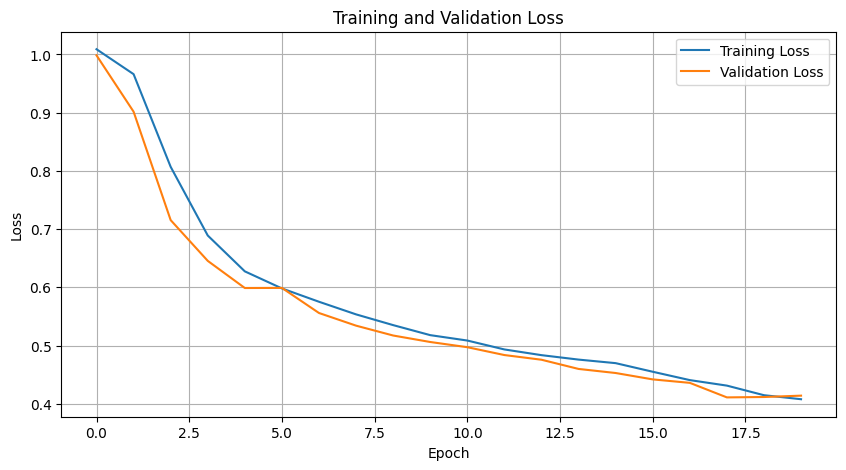

Evaluating: 100%|██████████| 27/27 [00:17<00:00,  1.57it/s]

Average Test Loss: 0.414007
Joint 1 MSE: 0.095891
Joint 2 MSE: 0.193271
Joint 3 MSE: 0.728514
Joint 4 MSE: 0.061468
Joint 5 MSE: 0.770385
Joint 6 MSE: 0.126372
Joint 7 MSE: 0.922149


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

class RobotCNNLSTM(nn.Module):
    """
    CNN+LSTM architecture for robot control from visual and proprioceptive input
    
    Architecture:
    1. CNN processes RGB images to extract visual features
    2. Visual features + proprioceptive data feed into LSTM
    3. LSTM output processed by MLP to predict joint positions
    """
    
    def __init__(self, 
                 image_channels=3,
                 proprio_dim=20,
                 action_dim=7,
                 lstm_hidden_dim=256,
                 cnn_feature_dim=512,
                 mlp_hidden_dim=128):
        super(RobotCNNLSTM, self).__init__()
        
        self.image_channels = image_channels
        self.proprio_dim = proprio_dim
        self.action_dim = action_dim
        self.lstm_hidden_dim = lstm_hidden_dim
        self.cnn_feature_dim = cnn_feature_dim
        
        # CNN for image feature extraction
        self.cnn = nn.Sequential(
            # Input: [batch, seq, channels, height, width]
            # Need to reshape for CNN processing
            
            # Layer 1: 3 -> 32 channels
            nn.Conv2d(image_channels, 32, kernel_size=8, stride=4, padding=2),
            nn.ReLU(),
            
            # Layer 2: 32 -> 64 channels
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            
            # Layer 3: 64 -> 64 channels
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            # Additional layers for larger images
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            
            # Adaptive pooling to ensure fixed output size
            nn.AdaptiveAvgPool2d((7, 7)),
        )
        
        # Calculate CNN output dimensions (empirically)
        self._cnn_output_dim = 128 * 7 * 7  # Based on adaptive pooling to 7x7
        
        # Linear layer to reduce CNN features
        self.cnn_to_features = nn.Sequential(
            nn.Flatten(),  # Flatten CNN output
            nn.Linear(self._cnn_output_dim, cnn_feature_dim),
            nn.ReLU()
        )
        
        # LSTM for temporal dynamics
        # Input: CNN features + proprioceptive data
        self.lstm = nn.LSTM(
            input_size=cnn_feature_dim + proprio_dim,
            hidden_size=lstm_hidden_dim,
            num_layers=2,  # 2-layer LSTM for more capacity
            batch_first=True,  # Input: [batch, seq, features]
            dropout=0.2
        )
        
        # MLP head for action prediction
        self.action_head = nn.Sequential(
            nn.Linear(lstm_hidden_dim, mlp_hidden_dim),
            nn.ReLU(),
            nn.Linear(mlp_hidden_dim, mlp_hidden_dim),
            nn.ReLU(),
            nn.Linear(mlp_hidden_dim, action_dim)
        )
        
    def forward(self, rgb, proprio):
        """
        Forward pass through the network
        
        Args:
            rgb: [batch, seq, channel, height, width] RGB images
            proprio: [batch, seq, proprio_dim] Proprioceptive features
            
        Returns:
            actions: [batch, seq, action_dim] Predicted actions
        """
        batch_size, seq_len = rgb.shape[0], rgb.shape[1]
        
        # Process images with CNN
        # Reshape to process all images at once
        rgb_reshaped = rgb.reshape(batch_size * seq_len, self.image_channels, rgb.shape[3], rgb.shape[4])
        
        # Pass through CNN and feature extractor
        cnn_features = self.cnn(rgb_reshaped)
        visual_features = self.cnn_to_features(cnn_features)
        
        # Reshape back to [batch, seq, feature]
        visual_features = visual_features.reshape(batch_size, seq_len, self.cnn_feature_dim)
        
        # Concatenate with proprioceptive data
        lstm_input = torch.cat([visual_features, proprio], dim=2)
        
        # Process with LSTM
        lstm_out, _ = self.lstm(lstm_input)
        
        # Predict actions (process all timesteps)
        actions = self.action_head(lstm_out)
        
        return actions
    
    def predict_single_step(self, rgb, proprio, hidden_state=None):
        """
        Make a single step prediction (for inference)
        
        Args:
            rgb: [batch, channel, height, width] RGB image
            proprio: [batch, proprio_dim] Proprioceptive features
            hidden_state: Previous LSTM hidden state (h, c) or None
            
        Returns:
            action: [batch, action_dim] Predicted action
            new_hidden_state: Updated LSTM hidden state
        """
        batch_size = rgb.shape[0]
        
        # Add sequence dimension for consistency
        if len(rgb.shape) == 4:
            rgb = rgb.unsqueeze(1)  # [batch, 1, channel, height, width]
        if len(proprio.shape) == 2:
            proprio = proprio.unsqueeze(1)  # [batch, 1, proprio_dim]
        
        # Get visual features
        cnn_features = self.cnn(rgb.reshape(batch_size, self.image_channels, rgb.shape[3], rgb.shape[4]))
        visual_features = self.cnn_to_features(cnn_features).unsqueeze(1)  # [batch, 1, cnn_feature_dim]
        
        # Combine with proprio
        lstm_input = torch.cat([visual_features, proprio], dim=2)
        
        # LSTM step
        if hidden_state is None:
            lstm_out, new_hidden_state = self.lstm(lstm_input)
        else:
            lstm_out, new_hidden_state = self.lstm(lstm_input, hidden_state)
        
        # Predict action
        action = self.action_head(lstm_out.squeeze(1))
        
        return action, new_hidden_state


def train_model(model, train_loader, val_loader, 
                num_epochs=20, learning_rate=1e-4, 
                weight_decay=1e-5, device='cuda'):
    """
    Train the robot control model
    
    Args:
        model: CNN+LSTM model
        train_loader: Training data loader
        val_loader: Validation data loader
        num_epochs: Number of training epochs
        learning_rate: Learning rate for optimizer
        weight_decay: L2 regularization strength
        device: 'cuda' or 'cpu'
    """
    model = model.to(device)
    
    # MSE loss for regression of joint positions
    criterion = nn.MSELoss()
    
    # Adam optimizer with weight decay
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )
    
    # Training history
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training loop
        model.train()
        train_loss = 0.0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for batch_idx, batch in enumerate(progress_bar):
            # Get batch data
            rgb = batch['rgb'].to(device)          # [B, seq, 3, H, W]
            proprio = batch['proprio'].to(device)  # [B, seq, proprio_dim]
            action_gt = batch['action'].to(device) # [B, seq, action_dim]
            
            # Forward pass
            optimizer.zero_grad()
            action_pred = model(rgb, proprio)
            
            # Compute loss
            loss = criterion(action_pred, action_gt)
            
            # Backward pass and optimize
            loss.backward()
            # Optional: gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
            optimizer.step()
            
            # Update progress
            train_loss += loss.item()
            progress_bar.set_postfix({"loss": loss.item()})
        
        # Calculate average training loss
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating"):
                rgb = batch['rgb'].to(device)
                proprio = batch['proprio'].to(device)
                action_gt = batch['action'].to(device)
                
                # Forward pass
                action_pred = model(rgb, proprio)
                loss = criterion(action_pred, action_gt)
                val_loss += loss.item()
        
        # Calculate average validation loss
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        # Update learning rate scheduler
        scheduler.step(val_loss)
        
        # Print epoch summary
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.6f}, "
              f"Val Loss: {val_loss:.6f}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
            }, "robot_cnn_lstm_best4o.pth")
    
    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('training_history.png')
    plt.show()
    
    return model


def evaluate_model(model, test_loader, device='cuda'):
    """
    Evaluate the model on test data
    """
    model = model.to(device)
    model.eval()
    
    criterion = nn.MSELoss()
    total_loss = 0.0
    
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            rgb = batch['rgb'].to(device)
            proprio = batch['proprio'].to(device)
            action_gt = batch['action'].to(device)
            
            # Forward pass
            action_pred = model(rgb, proprio)
            
            # Compute loss
            loss = criterion(action_pred, action_gt)
            total_loss += loss.item()
            
            # Store predictions and targets for analysis
            all_preds.append(action_pred.cpu().numpy())
            all_targets.append(action_gt.cpu().numpy())
    
    # Calculate average loss
    avg_loss = total_loss / len(test_loader)
    print(f"Average Test Loss: {avg_loss:.6f}")
    
    # Concatenate all predictions and targets
    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    
    # Compute per-joint MSE
    per_joint_mse = np.mean((all_preds - all_targets)**2, axis=(0, 1))
    for i, mse in enumerate(per_joint_mse):
        print(f"Joint {i+1} MSE: {mse:.6f}")
    
    return all_preds, all_targets, avg_loss


# Example usage
if __name__ == "__main__":
    # Assuming you've already set up your data loaders
    # from the previous code
    normalized_file = "E:\\roboarmsimulation\\robot_demos_20250708_115502\demonstrations_11_normalized.hdf5"
    
    # Fix your data loader splitting issue first
    def create_robot_data_loaders_fixed(hdf5_file, batch_size=16, val_split=0.1, sequence_length=1, skip_frames=1):
        """Fixed version that handles single-demo cases"""
        with h5py.File(hdf5_file, 'r') as f:
            all_demos = list(f['data'].keys())
        
        if len(all_demos) <= 1:
            print("⚠️ Only one demo found - using same demo for training and validation")
            train_demos = all_demos
            val_demos = all_demos
        else:
            np.random.shuffle(all_demos)
            split_idx = max(1, min(int(val_split * len(all_demos)), len(all_demos) - 1))
            val_demos = all_demos[:split_idx]
            train_demos = all_demos[split_idx:]
        
        train_dataset = RobotDemonstrationDataset(
            hdf5_file, demo_keys=train_demos, sequence_length=sequence_length,
            skip_frames=skip_frames, debug=True
        )
        
        val_dataset = RobotDemonstrationDataset(
            hdf5_file, demo_keys=val_demos, sequence_length=sequence_length,
            skip_frames=skip_frames, debug=True
        )
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
        
        return train_loader, val_loader
    
    # Create data loaders
    train_loader, val_loader = create_robot_data_loaders_fixed(
        normalized_file, batch_size=8, sequence_length=5, skip_frames=1
    )
    
    # Create model - adjust dimensions to match your data
    model = RobotCNNLSTM(
        image_channels=3,       # RGB images
        proprio_dim=20,         # Based on your dataset
        action_dim=7,           # 7 joint positions
        lstm_hidden_dim=256,
        cnn_feature_dim=512,
        mlp_hidden_dim=128
    )
    
    # Check if CUDA is available
    device = torch.device('cuda' if torch.cuda.is_available()  else 'cpu')
    print(f"Using device: {device}")
    
    # Train model
    model = train_model(
        model, train_loader, val_loader,
        num_epochs=20, 
        learning_rate=1e-4,
        device=device
    )
    
    # Evaluate model
    all_preds, all_targets, avg_loss = evaluate_model(model, val_loader, device)

Using device: cuda
✅ Model loaded from robot_cnn_lstm_best3.pth

1. DETAILED SAMPLE PREDICTIONS:

SAMPLE 1

Timestep 1:
----------------------------------------
Joint_1: Predicted= +0.4618, Actual= +0.7280, Error=  0.2661
Joint_2: Predicted= -0.6985, Actual= -1.0130, Error=  0.3145
Joint_3: Predicted= +0.0494, Actual= +0.1498, Error=  0.1005
Joint_4: Predicted= -0.3314, Actual= -0.6777, Error=  0.3463
Joint_5: Predicted= +0.1879, Actual= +0.2557, Error=  0.0678
Joint_6: Predicted= -0.3254, Actual= -0.5000, Error=  0.1746
Joint_7: Predicted= -0.3610, Actual= -0.1073, Error=  0.2537

Timestep 1 Metrics:
  MSE: 0.057026
  MAE: 0.217642

Timestep 2:
----------------------------------------
Joint_1: Predicted= +0.7182, Actual= +0.7280, Error=  0.0098
Joint_2: Predicted= -0.9624, Actual= -1.0130, Error=  0.0506
Joint_3: Predicted= +0.1666, Actual= +0.1498, Error=  0.0167
Joint_4: Predicted= -0.6212, Actual= -0.6777, Error=  0.0565
Joint_5: Predicted= +0.2411, Actual= +0.2557, Error=  0.0147


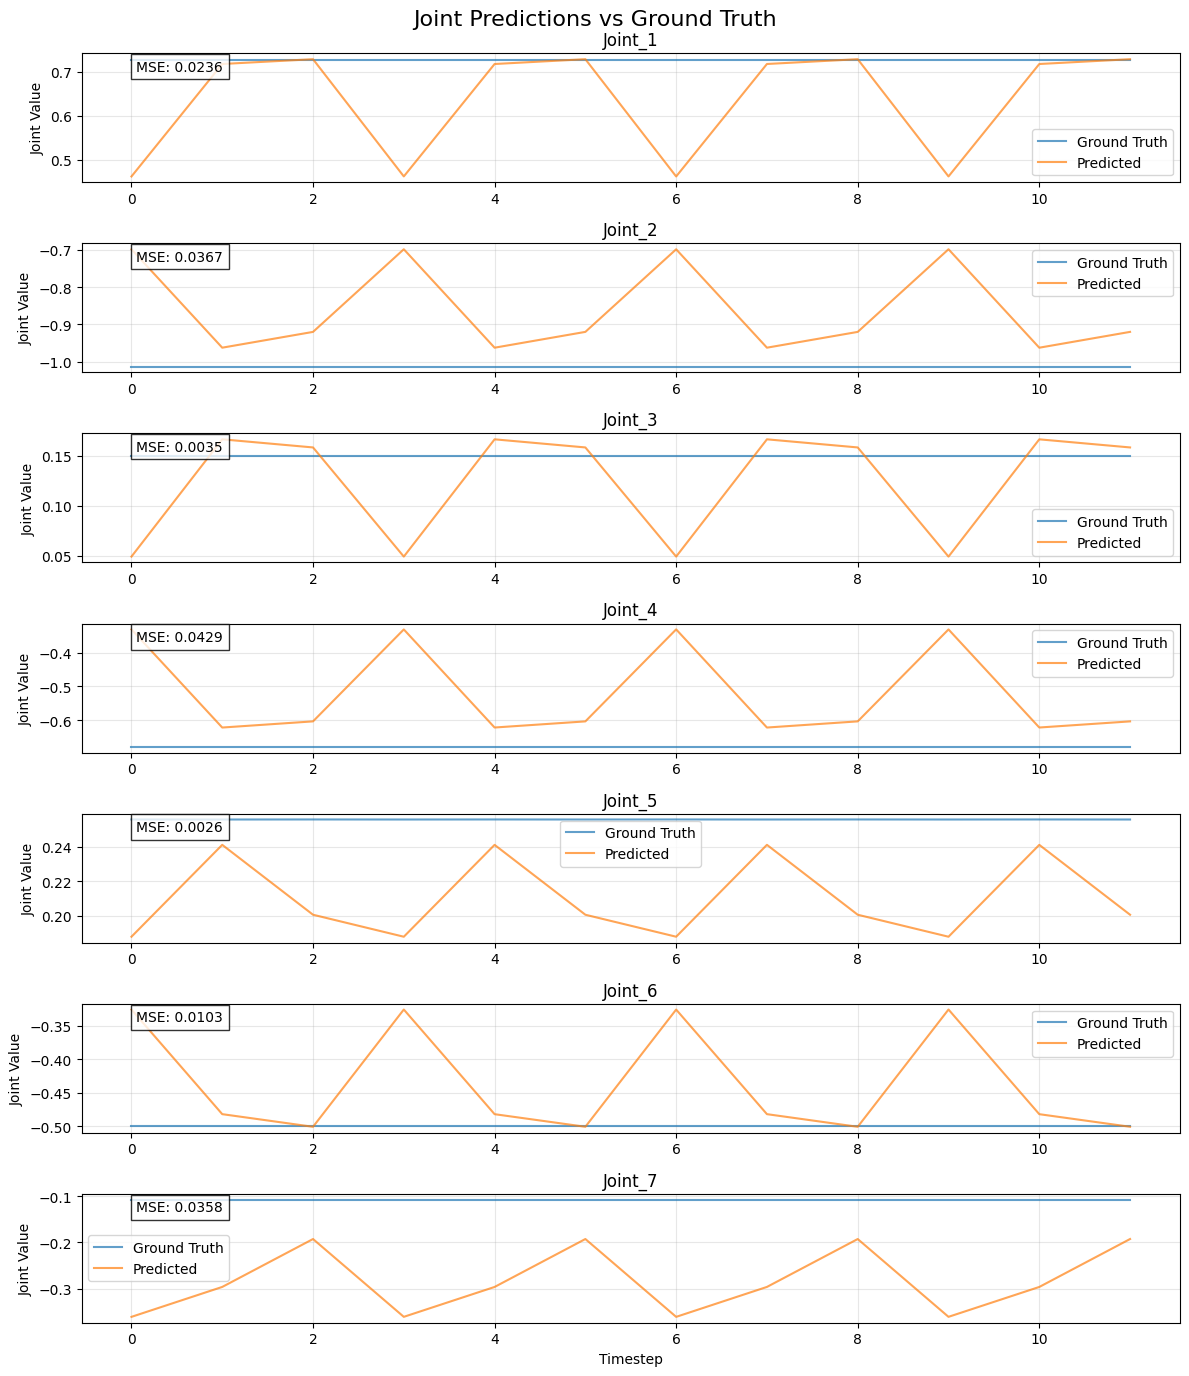


4. SINGLE FRAME PREDICTION EXAMPLE:

SINGLE FRAME PREDICTION
Joint_1:  +0.4618
Joint_2:  -0.6984
Joint_3:  +0.0494
Joint_4:  -0.3315
Joint_5:  +0.1880
Joint_6:  -0.3254
Joint_7:  -0.3609


In [ ]:
import torch
import numpy as np
import h5py
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def load_trained_model(model_path, device='cuda'):
    """Load the trained CNN+LSTM model"""
    # Create model with same architecture as training
    model = RobotCNNLSTM(
        image_channels=3,
        proprio_dim=20,
        action_dim=7,
        lstm_hidden_dim=256,
        cnn_feature_dim=512,
        mlp_hidden_dim=128
    )
    
    # Load trained weights
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    print(f"✅ Model loaded from {model_path}")
    return model

def predict_and_print_joints(model, data_loader, device='cuda', num_samples=10):
    """
    Make predictions and print joint values for specified number of samples
    """
    model.eval()
    joint_names = ['Joint_1', 'Joint_2', 'Joint_3', 'Joint_4', 'Joint_5', 'Joint_6', 'Joint_7']
    
    sample_count = 0
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loader):
            if sample_count >= num_samples:
                break
                
            # Get batch data
            rgb = batch['rgb'].to(device)          # [B, seq, 3, H, W]
            proprio = batch['proprio'].to(device)  # [B, seq, proprio_dim]
            action_gt = batch['action'].to(device) # [B, seq, action_dim]
            
            # Make predictions
            action_pred = model(rgb, proprio)
            
            # Convert to numpy for easier handling
            pred_np = action_pred.cpu().numpy()
            gt_np = action_gt.cpu().numpy()
            
            # Process each sample in the batch
            batch_size, seq_len, _ = pred_np.shape
            
            for b in range(batch_size):
                if sample_count >= num_samples:
                    break
                    
                print(f"\n{'='*60}")
                print(f"SAMPLE {sample_count + 1}")
                print(f"{'='*60}")
                
                # Show predictions for each timestep in the sequence
                for t in range(seq_len):
                    print(f"\nTimestep {t + 1}:")
                    print("-" * 40)
                    
                    # Print each joint prediction vs ground truth
                    for joint_idx in range(7):
                        predicted_val = pred_np[b, t, joint_idx]
                        ground_truth_val = gt_np[b, t, joint_idx]
                        error = abs(predicted_val - ground_truth_val)
                        
                        print(f"{joint_names[joint_idx]}: "
                              f"Predicted={predicted_val:+8.4f}, "
                              f"Actual={ground_truth_val:+8.4f}, "
                              f"Error={error:8.4f}")
                    
                    # Calculate and print overall metrics for this timestep
                    timestep_pred = pred_np[b, t, :]
                    timestep_gt = gt_np[b, t, :]
                    mse = np.mean((timestep_pred - timestep_gt)**2)
                    mae = np.mean(np.abs(timestep_pred - timestep_gt))
                    
                    print(f"\nTimestep {t + 1} Metrics:")
                    print(f"  MSE: {mse:.6f}")
                    print(f"  MAE: {mae:.6f}")
                
                sample_count += 1
    
    print(f"\n{'='*60}")
    print(f"Completed predictions for {sample_count} samples")
    print(f"{'='*60}")

def predict_single_frame(model, rgb_image, proprio_data, device='cuda'):
    """
    Make prediction for a single frame and print joint values
    """
    model.eval()
    joint_names = ['Joint_1', 'Joint_2', 'Joint_3', 'Joint_4', 'Joint_5', 'Joint_6', 'Joint_7']
    
    # Ensure inputs are tensors and have correct shapes
    if isinstance(rgb_image, np.ndarray):
        rgb_image = torch.tensor(rgb_image, dtype=torch.float32)
    if isinstance(proprio_data, np.ndarray):
        proprio_data = torch.tensor(proprio_data, dtype=torch.float32)
    
    # Add batch and sequence dimensions if needed
    if len(rgb_image.shape) == 3:  # [C, H, W]
        rgb_image = rgb_image.unsqueeze(0).unsqueeze(0)  # [1, 1, C, H, W]
    elif len(rgb_image.shape) == 4:  # [B, C, H, W]
        rgb_image = rgb_image.unsqueeze(1)  # [B, 1, C, H, W]
    
    if len(proprio_data.shape) == 1:  # [proprio_dim]
        proprio_data = proprio_data.unsqueeze(0).unsqueeze(0)  # [1, 1, proprio_dim]
    elif len(proprio_data.shape) == 2:  # [B, proprio_dim]
        proprio_data = proprio_data.unsqueeze(1)  # [B, 1, proprio_dim]
    
    rgb_image = rgb_image.to(device)
    proprio_data = proprio_data.to(device)
    
    with torch.no_grad():
        prediction = model(rgb_image, proprio_data)
        pred_joints = prediction.squeeze().cpu().numpy()
    
    print("\n" + "="*50)
    print("SINGLE FRAME PREDICTION")
    print("="*50)
    
    for joint_idx, joint_name in enumerate(joint_names):
        print(f"{joint_name}: {pred_joints[joint_idx]:+8.4f}")
    
    return pred_joints

def analyze_joint_predictions(model, data_loader, device='cuda', num_batches=5):
    """
    Analyze predictions across multiple batches and show statistics
    """
    model.eval()
    joint_names = ['Joint_1', 'Joint_2', 'Joint_3', 'Joint_4', 'Joint_5', 'Joint_6', 'Joint_7']
    
    all_predictions = []
    all_ground_truth = []
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loader):
            if batch_idx >= num_batches:
                break
                
            rgb = batch['rgb'].to(device)
            proprio = batch['proprio'].to(device)
            action_gt = batch['action'].to(device)
            
            # Make predictions
            action_pred = model(rgb, proprio)
            
            # Store for analysis
            all_predictions.append(action_pred.cpu().numpy())
            all_ground_truth.append(action_gt.cpu().numpy())
    
    # Combine all predictions
    all_predictions = np.concatenate(all_predictions, axis=0)  # [total_samples, seq_len, 7]
    all_ground_truth = np.concatenate(all_ground_truth, axis=0)
    
    # Reshape to [total_timesteps, 7]
    pred_reshaped = all_predictions.reshape(-1, 7)
    gt_reshaped = all_ground_truth.reshape(-1, 7)
    
    print("\n" + "="*70)
    print("JOINT PREDICTION ANALYSIS")
    print("="*70)
    
    for joint_idx, joint_name in enumerate(joint_names):
        pred_joint = pred_reshaped[:, joint_idx]
        gt_joint = gt_reshaped[:, joint_idx]
        
        # Calculate statistics
        mse = np.mean((pred_joint - gt_joint)**2)
        mae = np.mean(np.abs(pred_joint - gt_joint))
        pred_mean = np.mean(pred_joint)
        pred_std = np.std(pred_joint)
        gt_mean = np.mean(gt_joint)
        gt_std = np.std(gt_joint)
        
        print(f"\n{joint_name}:")
        print(f"  MSE: {mse:.6f}")
        print(f"  MAE: {mae:.6f}")
        print(f"  Predicted - Mean: {pred_mean:+8.4f}, Std: {pred_std:8.4f}")
        print(f"  Actual    - Mean: {gt_mean:+8.4f}, Std: {gt_std:8.4f}")
        print(f"  Range - Pred: [{np.min(pred_joint):+8.4f}, {np.max(pred_joint):+8.4f}]")
        print(f"          Actual: [{np.min(gt_joint):+8.4f}, {np.max(gt_joint):+8.4f}]")

def visualize_joint_predictions(model, data_loader, device='cuda', num_samples=3):
    """
    Create visualization of joint predictions vs ground truth
    """
    model.eval()
    joint_names = ['Joint_1', 'Joint_2', 'Joint_3', 'Joint_4', 'Joint_5', 'Joint_6', 'Joint_7']
    
    fig, axes = plt.subplots(7, 1, figsize=(12, 14))
    fig.suptitle('Joint Predictions vs Ground Truth', fontsize=16)
    
    sample_count = 0
    all_pred = [[] for _ in range(7)]
    all_gt = [[] for _ in range(7)]
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loader):
            if sample_count >= num_samples:
                break
                
            rgb = batch['rgb'].to(device)
            proprio = batch['proprio'].to(device)
            action_gt = batch['action'].to(device)
            
            action_pred = model(rgb, proprio)
            
            # Convert to numpy and flatten sequences
            pred_np = action_pred.cpu().numpy().reshape(-1, 7)
            gt_np = action_gt.cpu().numpy().reshape(-1, 7)
            
            for joint_idx in range(7):
                all_pred[joint_idx].extend(pred_np[:, joint_idx])
                all_gt[joint_idx].extend(gt_np[:, joint_idx])
            
            sample_count += pred_np.shape[0]
    
    # Plot each joint
    for joint_idx in range(7):
        axes[joint_idx].plot(all_gt[joint_idx], label='Ground Truth', alpha=0.7)
        axes[joint_idx].plot(all_pred[joint_idx], label='Predicted', alpha=0.7)
        axes[joint_idx].set_title(f'{joint_names[joint_idx]}')
        axes[joint_idx].set_ylabel('Joint Value')
        axes[joint_idx].legend()
        axes[joint_idx].grid(True, alpha=0.3)

        mse=np.mean((np.array(all_pred[joint_idx]) - np.array(all_gt[joint_idx]))**2)
        axes[joint_idx].text(0.05, 0.95, f'MSE: {mse:.4f}', transform=axes[joint_idx].transAxes,
                             fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
    
    axes[-1].set_xlabel('Timestep')
    plt.tight_layout()
    plt.savefig('joint_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

# Main execution
if __name__ == "__main__":
    # Configuration
    normalized_file = "E:\\roboarmsimulation\\robot_demos_20250703_132514\demonstrations_11_normalized.hdf5"
    model_path = "robot_cnn_lstm_best40.pth"
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    print(f"Using device: {device}")
    
    # Create data loader
    train_loader, val_loader = create_robot_data_loaders_fixed(
        normalized_file, batch_size=4, sequence_length=3, skip_frames=1
    )
    
    # Load trained model
    model = load_trained_model(model_path, device)
    
    # 1. Print detailed predictions for specific samples
    print("\n1. DETAILED SAMPLE PREDICTIONS:")
    predict_and_print_joints(model, val_loader, device, num_samples=3)
    
    # 2. Analyze overall prediction statistics
    print("\n2. OVERALL PREDICTION ANALYSIS:")
    analyze_joint_predictions(model, val_loader, device, num_batches=10)
    
    # 3. Visualize predictions
    print("\n3. CREATING VISUALIZATION...")
    visualize_joint_predictions(model, val_loader, device, num_samples=5)
    
    # 4. Example of single frame prediction
    print("\n4. SINGLE FRAME PREDICTION EXAMPLE:")
    # Get a single sample from the loader
    for batch in val_loader:
        rgb_sample = batch['rgb'][0, 0]  # First sample, first timestep
        proprio_sample = batch['proprio'][0, 0]  # First sample, first timestep
        
        predicted_joints = predict_single_frame(model, rgb_sample, proprio_sample, device)
        break

Using device: cuda
⚠️ Only one demo found - using same demo for training and validation
✅ Model loaded from robot_cnn_lstm_best4o.pth

1. OVERALL PREDICTION ANALYSIS:

JOINT PREDICTION ANALYSIS

Joint_1:
  MSE: 0.027495
  MAE: 0.132620
  Predicted - Mean:  +0.0162, Std:   0.8974
  Actual    - Mean:  +0.0695, Std:   0.8954
  Range - Pred: [ -1.5046,  +0.9598]
          Actual: [ -1.5476,  +0.7016]

Joint_2:
  MSE: 0.150895
  MAE: 0.299829
  Predicted - Mean:  +0.4332, Std:   0.9861
  Actual    - Mean:  +0.4760, Std:   1.0677
  Range - Pred: [ -1.0159,  +1.8556]
          Actual: [ -1.5452,  +1.7815]

Joint_3:
  MSE: 0.148945
  MAE: 0.299196
  Predicted - Mean:  +0.1135, Std:   0.3775
  Actual    - Mean:  -0.0972, Std:   0.3836
  Range - Pred: [ -0.6418,  +0.8576]
          Actual: [ -0.9984,  +0.9517]

Joint_4:
  MSE: 0.051703
  MAE: 0.129357
  Predicted - Mean:  -0.0423, Std:   0.9711
  Actual    - Mean:  +0.0005, Std:   0.9920
  Range - Pred: [ -0.8937,  +1.6872]
          Actual: [ -

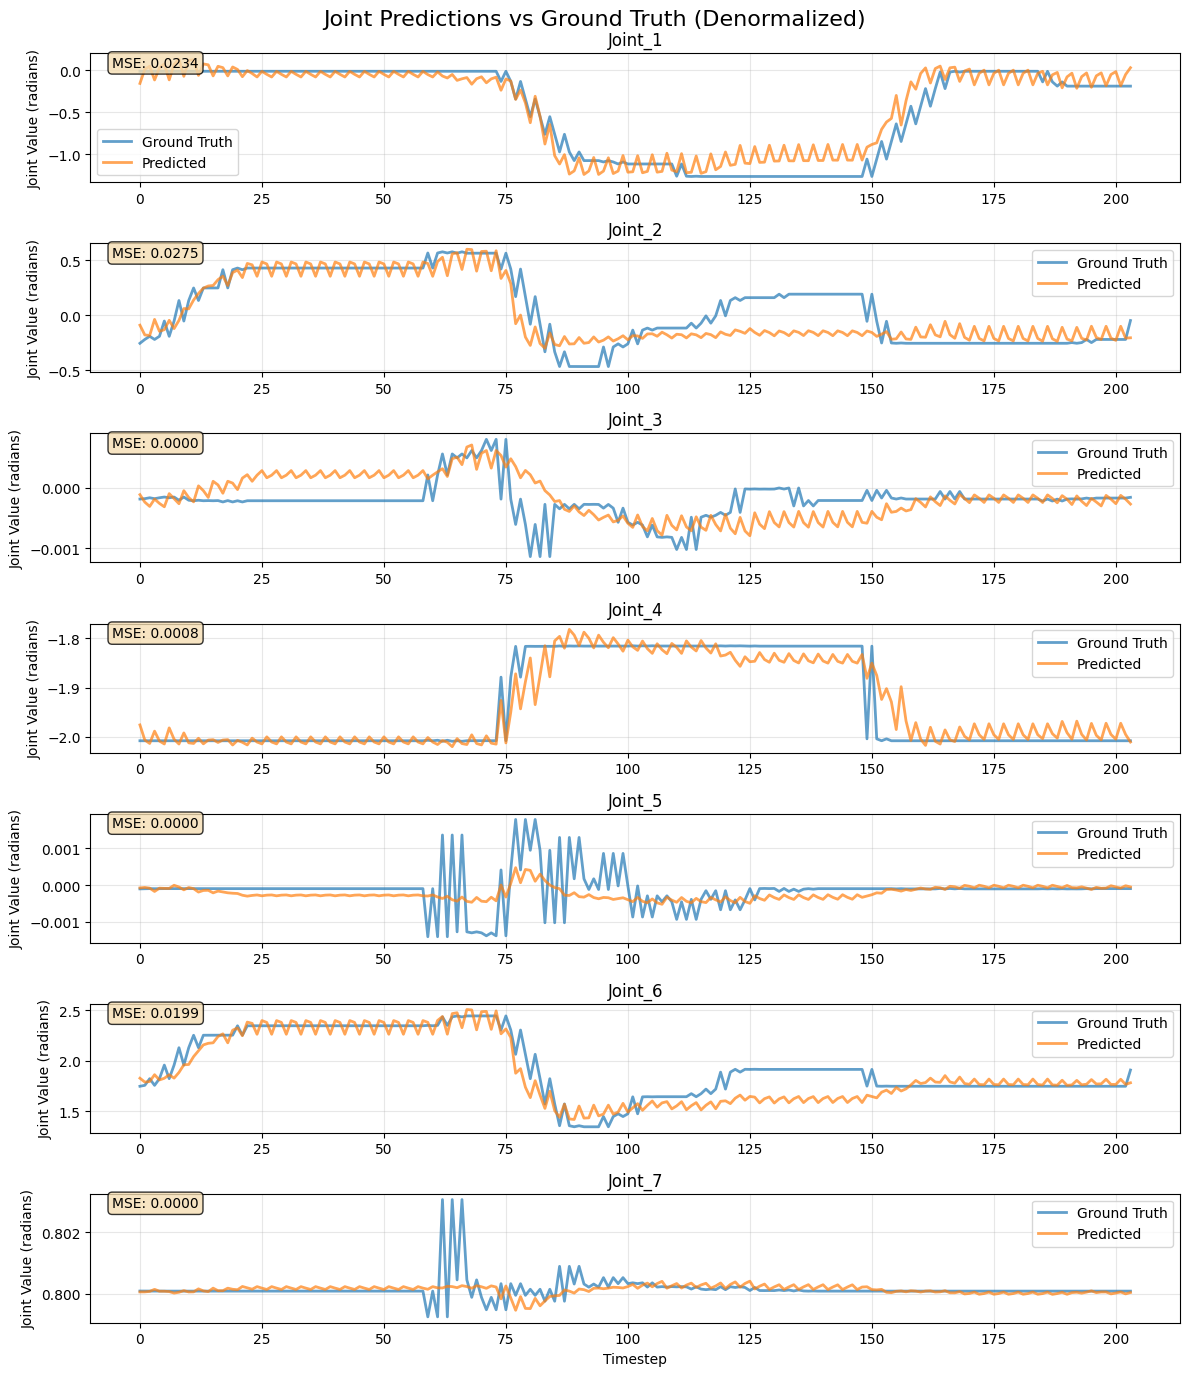

In [6]:
import torch
import numpy as np
import h5py
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def load_trained_model(model_path, device='cuda'):
    """Load the trained CNN+LSTM model"""
    # Create model with same architecture as training
    model = RobotCNNLSTM(
        image_channels=3,
        proprio_dim=20,
        action_dim=7,
        lstm_hidden_dim=256,
        cnn_feature_dim=512,
        mlp_hidden_dim=128
    )
    
    # Load trained weights
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    print(f"✅ Model loaded from {model_path}")
    return model

def predict_and_print_joints(model, data_loader, device='cuda', num_samples=10):
    """
    Make predictions and print joint values for specified number of samples
    """
    model.eval()
    joint_names = ['Joint_1', 'Joint_2', 'Joint_3', 'Joint_4', 'Joint_5', 'Joint_6', 'Joint_7']
    
    sample_count = 0
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loader):
            if sample_count >= num_samples:
                break
                
            # Get batch data
            rgb = batch['rgb'].to(device)          # [B, seq, 3, H, W]
            proprio = batch['proprio'].to(device)  # [B, seq, proprio_dim]
            action_gt = batch['action'].to(device) # [B, seq, action_dim]
            
            # Make predictions
            action_pred = model(rgb, proprio)
            
            # Convert to numpy for easier handling
            pred_np = action_pred.cpu().numpy()
            gt_np = action_gt.cpu().numpy()
            
            # Process each sample in the batch
            batch_size, seq_len, _ = pred_np.shape
            
            for b in range(batch_size):
                if sample_count >= num_samples:
                    break
                    
                print(f"\n{'='*60}")
                print(f"SAMPLE {sample_count + 1}")
                print(f"{'='*60}")
                
                # Show predictions for each timestep in the sequence
                for t in range(seq_len):
                    print(f"\nTimestep {t + 1}:")
                    print("-" * 40)
                    
                    # Print each joint prediction vs ground truth
                    for joint_idx in range(7):
                        predicted_val = pred_np[b, t, joint_idx]
                        ground_truth_val = gt_np[b, t, joint_idx]
                        error = abs(predicted_val - ground_truth_val)
                        
                        print(f"{joint_names[joint_idx]}: "
                              f"Predicted={predicted_val:+8.4f}, "
                              f"Actual={ground_truth_val:+8.4f}, "
                              f"Error={error:8.4f}")
                    
                    # Calculate and print overall metrics for this timestep
                    timestep_pred = pred_np[b, t, :]
                    timestep_gt = gt_np[b, t, :]
                    mse = np.mean((timestep_pred - timestep_gt)**2)
                    mae = np.mean(np.abs(timestep_pred - timestep_gt))
                    
                    print(f"\nTimestep {t + 1} Metrics:")
                    print(f"  MSE: {mse:.6f}")
                    print(f"  MAE: {mae:.6f}")
                
                sample_count += 1
    
    print(f"\n{'='*60}")
    print(f"Completed predictions for {sample_count} samples")
    print(f"{'='*60}")

def predict_single_frame(model, rgb_image, proprio_data, device='cuda'):
    """
    Make prediction for a single frame and print joint values
    """
    model.eval()
    joint_names = ['Joint_1', 'Joint_2', 'Joint_3', 'Joint_4', 'Joint_5', 'Joint_6', 'Joint_7']
    
    # Ensure inputs are tensors and have correct shapes
    if isinstance(rgb_image, np.ndarray):
        rgb_image = torch.tensor(rgb_image, dtype=torch.float32)
    if isinstance(proprio_data, np.ndarray):
        proprio_data = torch.tensor(proprio_data, dtype=torch.float32)
    
    # Add batch and sequence dimensions if needed
    if len(rgb_image.shape) == 3:  # [C, H, W]
        rgb_image = rgb_image.unsqueeze(0).unsqueeze(0)  # [1, 1, C, H, W]
    elif len(rgb_image.shape) == 4:  # [B, C, H, W]
        rgb_image = rgb_image.unsqueeze(1)  # [B, 1, C, H, W]
    
    if len(proprio_data.shape) == 1:  # [proprio_dim]
        proprio_data = proprio_data.unsqueeze(0).unsqueeze(0)  # [1, 1, proprio_dim]
    elif len(proprio_data.shape) == 2:  # [B, proprio_dim]
        proprio_data = proprio_data.unsqueeze(1)  # [B, 1, proprio_dim]
    
    rgb_image = rgb_image.to(device)
    proprio_data = proprio_data.to(device)
    
    with torch.no_grad():
        prediction = model(rgb_image, proprio_data)
        pred_joints = prediction.squeeze().cpu().numpy()
    
    print("\n" + "="*50)
    print("SINGLE FRAME PREDICTION")
    print("="*50)
    
    for joint_idx, joint_name in enumerate(joint_names):
        print(f"{joint_name}: {pred_joints[joint_idx]:+8.4f}")
    
    return pred_joints

def analyze_joint_predictions(model, data_loader, device='cuda', num_batches=5):
    """
    Analyze predictions across multiple batches and show statistics
    """
    model.eval()
    joint_names = ['Joint_1', 'Joint_2', 'Joint_3', 'Joint_4', 'Joint_5', 'Joint_6', 'Joint_7']
    
    all_predictions = []
    all_ground_truth = []
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loader):
            if batch_idx >= num_batches:
                break
                
            rgb = batch['rgb'].to(device)
            proprio = batch['proprio'].to(device)
            action_gt = batch['action'].to(device)
            
            # Make predictions
            action_pred = model(rgb, proprio)
            
            # Store for analysis
            all_predictions.append(action_pred.cpu().numpy())
            all_ground_truth.append(action_gt.cpu().numpy())
    
    # Combine all predictions
    all_predictions = np.concatenate(all_predictions, axis=0)  # [total_samples, seq_len, 7]
    all_ground_truth = np.concatenate(all_ground_truth, axis=0)
    
    # Reshape to [total_timesteps, 7]
    pred_reshaped = all_predictions.reshape(-1, 7)
    gt_reshaped = all_ground_truth.reshape(-1, 7)
    
    print("\n" + "="*70)
    print("JOINT PREDICTION ANALYSIS")
    print("="*70)
    
    for joint_idx, joint_name in enumerate(joint_names):
        pred_joint = pred_reshaped[:, joint_idx]
        gt_joint = gt_reshaped[:, joint_idx]
        
        # Calculate statistics
        mse = np.mean((pred_joint - gt_joint)**2)
        mae = np.mean(np.abs(pred_joint - gt_joint))
        pred_mean = np.mean(pred_joint)
        pred_std = np.std(pred_joint)
        gt_mean = np.mean(gt_joint)
        gt_std = np.std(gt_joint)
        
        print(f"\n{joint_name}:")
        print(f"  MSE: {mse:.6f}")
        print(f"  MAE: {mae:.6f}")
        print(f"  Predicted - Mean: {pred_mean:+8.4f}, Std: {pred_std:8.4f}")
        print(f"  Actual    - Mean: {gt_mean:+8.4f}, Std: {gt_std:8.4f}")
        print(f"  Range - Pred: [{np.min(pred_joint):+8.4f}, {np.max(pred_joint):+8.4f}]")
        print(f"          Actual: [{np.min(gt_joint):+8.4f}, {np.max(gt_joint):+8.4f}]")

def visualize_joint_predictions_with_denormalization(model, data_loader, device='cuda', num_samples=100):
    """
    Create visualization of joint predictions vs ground truth with proper denormalization
    """
    model.eval()
    joint_names = ['Joint_1', 'Joint_2', 'Joint_3', 'Joint_4', 'Joint_5', 'Joint_6', 'Joint_7']
    
    # Load normalization parameters from the normalized file
    normalized_file = "E:\\roboarmsimulation\\robot_demos_20250703_132514\\demonstrations_11_normalized.hdf5"
    
    with h5py.File(normalized_file, 'r') as f:
        if 'normalization' in f and 'action_mean' in f['normalization']:
            action_mean = f['normalization']['action_mean'][:]
            action_std = f['normalization']['action_std'][:]
            print("✅ Found normalization parameters - will denormalize data")
            print(f"Action mean: {action_mean}")
            print(f"Action std: {action_std}")
        else:
            print("⚠️ No normalization parameters found - using raw normalized values")
            action_mean = np.zeros(7)
            action_std = np.ones(7)
    
    fig, axes = plt.subplots(7, 1, figsize=(12, 14))
    fig.suptitle('Joint Predictions vs Ground Truth (Denormalized)', fontsize=16)
    
    sample_count = 0
    all_pred = [[] for _ in range(7)]
    all_gt = [[] for _ in range(7)]
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loader):
            if sample_count >= num_samples:
                break
                
            rgb = batch['rgb'].to(device)
            proprio = batch['proprio'].to(device)
            action_gt = batch['action'].to(device)
            
            action_pred = model(rgb, proprio)
            
            # Convert to numpy and flatten sequences
            pred_np = action_pred.cpu().numpy().reshape(-1, 7)
            gt_np = action_gt.cpu().numpy().reshape(-1, 7)
            
            # DENORMALIZE BOTH PREDICTIONS AND GROUND TRUTH
            pred_denorm = pred_np * action_std + action_mean
            gt_denorm = gt_np * action_std + action_mean
            
            # Collect denormalized data for each joint
            for joint_idx in range(7):
                all_pred[joint_idx].extend(pred_denorm[:, joint_idx])
                all_gt[joint_idx].extend(gt_denorm[:, joint_idx])
            
            sample_count += pred_np.shape[0]
    
    # Plot each joint with denormalized values
    for joint_idx in range(7):
        axes[joint_idx].plot(all_gt[joint_idx], label='Ground Truth', alpha=0.7, linewidth=2)
        axes[joint_idx].plot(all_pred[joint_idx], label='Predicted', alpha=0.7, linewidth=2)
        axes[joint_idx].set_title(f'{joint_names[joint_idx]}')
        axes[joint_idx].set_ylabel('Joint Value (radians)')
        axes[joint_idx].legend()
        axes[joint_idx].grid(True, alpha=0.3)
        
        # Calculate MSE on denormalized data
        mse = np.mean((np.array(all_pred[joint_idx]) - np.array(all_gt[joint_idx]))**2)
        axes[joint_idx].text(0.02, 0.98, f'MSE: {mse:.4f}', 
                           transform=axes[joint_idx].transAxes, 
                           verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        # Print statistics to verify the data has variation
        gt_range = np.max(all_gt[joint_idx]) - np.min(all_gt[joint_idx])
        gt_std = np.std(all_gt[joint_idx])
        print(f"{joint_names[joint_idx]} denormalized:")
        print(f"  Range: {gt_range:.4f} radians")
        print(f"  Std: {gt_std:.4f}")
        print(f"  Min: {np.min(all_gt[joint_idx]):+8.4f}")
        print(f"  Max: {np.max(all_gt[joint_idx]):+8.4f}")
    
    axes[-1].set_xlabel('Timestep')
    plt.tight_layout()
    plt.savefig('joint_predictions_denormalized.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return all_pred, all_gt

# Main execution
# Replace your current visualization call with this:

# Main execution
if __name__ == "__main__":
    # Configuration
    normalized_file = "E:\\roboarmsimulation\\robot_demos_20250708_115502\demonstrations_11_normalized.hdf5"
    model_path = "robot_cnn_lstm_best4o.pth"  # Update to your actual model file
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    print(f"Using device: {device}")
    
    # Create data loader
    train_loader, val_loader = create_robot_data_loaders_fixed(
        normalized_file, batch_size=4, sequence_length=3, skip_frames=1
    )
    
    # Load trained model
    try:
        model = load_trained_model(model_path, device)
        
        # 1. Analyze overall prediction statistics
        print("\n1. OVERALL PREDICTION ANALYSIS:")
        analyze_joint_predictions(model, val_loader, device, num_batches=10)
        
        # 2. Visualize predictions with proper denormalization
        print("\n2. CREATING DENORMALIZED VISUALIZATION:")
        pred_data, gt_data = visualize_joint_predictions_with_denormalization(
            model, val_loader, device, num_samples=200
        )
        
    except FileNotFoundError:
        print(f"❌ Model file not found: {model_path}")
        print("Available .pth files:")
        import glob
        pth_files = glob.glob("*.pth")
        for file in pth_files:
            print(f"  - {file}")

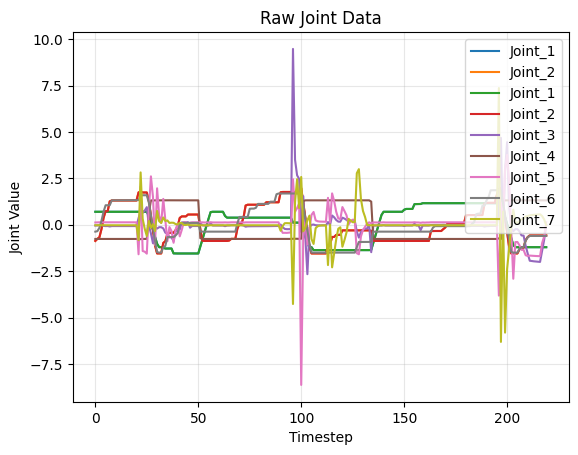

In [7]:
import h5py
import matplotlib.pyplot as plt

file_path = 'E:\\roboarmsimulation\\robot_demos_20250708_115502\\demonstrations_11_normalized.hdf5'
with h5py.File(file_path, 'r') as f:
    # Correct path: f['data']['demo_1']['actions']
    joint_data = f['data']['demo_1']['actions'][:]  # ✅ Correct path

plt.plot(joint_data[:, 0], label='Joint_1')
plt.plot(joint_data[:, 1], label='Joint_2')
# Add more joints if needed
for i in range(min(7, joint_data.shape[1])):
    plt.plot(joint_data[:, i], label=f'Joint_{i+1}')

plt.legend()
plt.title("Raw Joint Data")
plt.xlabel("Timestep")
plt.ylabel("Joint Value")
plt.grid(True, alpha=0.3)
plt.show()

🔍 COMPARING ORIGINAL VS NORMALIZED DATA:

Original data shape: (163, 7)
Original data statistics:
  Joint_1: Min= -1.3970, Max= +0.0001, Mean= -0.4483, Std=  0.5684
  Joint_2: Min= -0.5002, Max= +0.5053, Mean= +0.0354, Std=  0.2996
  Joint_3: Min= -0.0011, Max= +0.0038, Mean= +0.0001, Std=  0.0005
  Joint_4: Min= -2.0000, Max= -1.7999, Mean= -1.9431, Std=  0.0898
  Joint_5: Min= -0.0009, Max= +0.0023, Mean= +0.0000, Std=  0.0003
  Joint_6: Min= +1.2967, Max= +2.5438, Mean= +1.8992, Std=  0.3314
  Joint_7: Min= +0.7987, Max= +0.8044, Mean= +0.8001, Std=  0.0005

Normalized data shape: (163, 7)
Normalized data statistics:
  Joint_1: Min= -1.7840, Max= +0.7280, Mean= -0.0781, Std=  1.0220
  Joint_2: Min= -1.6516, Max= +1.5553, Mean= +0.0567, Std=  0.9556
  Joint_3: Min= -0.9258, Max= +4.0343, Mean= +0.2322, Std=  0.4820
  Joint_4: Min= -0.6777, Max= +1.4906, Mean= -0.0608, Std=  0.9732
  Joint_5: Min= -0.9002, Max= +3.2388, Mean= +0.2930, Std=  0.4294
  Joint_6: Min= -1.6373, Max= +1.8794

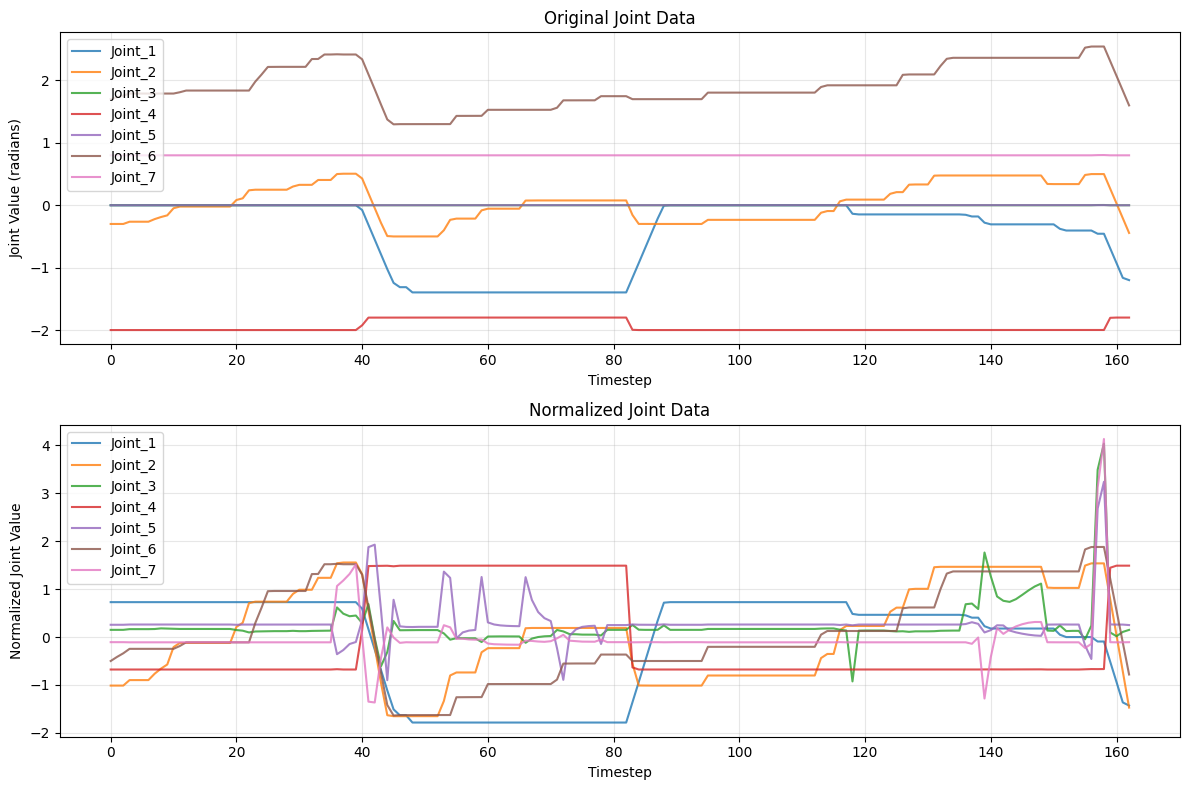

In [30]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

# Check both original and normalized data
original_file = 'E:\\roboarmsimulation\\robot_demos_20250703_132514\\demonstrations_11.hdf5'
normalized_file = 'E:\\roboarmsimulation\\robot_demos_20250703_132514\\demonstrations_11_normalized.hdf5'

print("🔍 COMPARING ORIGINAL VS NORMALIZED DATA:")

# Check original data
with h5py.File(original_file, 'r') as f:
    original_actions = f['data']['demo_1']['actions'][:]
    print(f"\nOriginal data shape: {original_actions.shape}")
    print("Original data statistics:")
    for i in range(min(7, original_actions.shape[1])):
        joint_data = original_actions[:, i]
        print(f"  Joint_{i+1}: Min={np.min(joint_data):+8.4f}, Max={np.max(joint_data):+8.4f}, "
              f"Mean={np.mean(joint_data):+8.4f}, Std={np.std(joint_data):8.4f}")

# Check normalized data
with h5py.File(normalized_file, 'r') as f:
    normalized_actions = f['data']['demo_1']['actions'][:]
    print(f"\nNormalized data shape: {normalized_actions.shape}")
    print("Normalized data statistics:")
    for i in range(min(7, normalized_actions.shape[1])):
        joint_data = normalized_actions[:, i]
        print(f"  Joint_{i+1}: Min={np.min(joint_data):+8.4f}, Max={np.max(joint_data):+8.4f}, "
              f"Mean={np.mean(joint_data):+8.4f}, Std={np.std(joint_data):8.4f}")

# Plot comparison
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot original data
for i in range(min(7, original_actions.shape[1])):
    ax1.plot(original_actions[:, i], label=f'Joint_{i+1}', alpha=0.8)
ax1.set_title("Original Joint Data")
ax1.set_xlabel("Timestep")
ax1.set_ylabel("Joint Value (radians)")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot normalized data
for i in range(min(7, normalized_actions.shape[1])):
    ax2.plot(normalized_actions[:, i], label=f'Joint_{i+1}', alpha=0.8)
ax2.set_title("Normalized Joint Data")
ax2.set_xlabel("Timestep")  
ax2.set_ylabel("Normalized Joint Value")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()